In [23]:
# import and mount drive
import cv2
import numpy as np
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [51]:
# load images
catimages = []
catimages_num = 393
for i in range(catimages_num):
    img_file = '/gdrive/MyDrive/CS/Image Classifier/ImageCat/cat' + str(i) + '.jpg'
    img = cv2.imread(img_file)

    catimages.append(img)

dogimages = []
dogimages_num = 401
for i in range(dogimages_num):
    img_file = '/gdrive/MyDrive/CS/Image Classifier/ImageDog/dog' + str(i) + '.jpg'
    img = cv2.imread(img_file)

    dogimages.append(img)
imgHeight = len(catimages[0][0])
imgChannel = len(catimages[0][0][0])

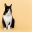

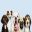

In [52]:
from google.colab.patches import cv2_imshow
# resize images to 32 * 32 pixels
for i in range(catimages_num):
    catimages[i] = cv2.resize(catimages[i], dsize=(32, 32), interpolation=cv2.INTER_AREA)

cv2_imshow(catimages[0])
print()

for i in range(dogimages_num):
    dogimages[i] = cv2.resize(dogimages[i], dsize=(32, 32), interpolation=cv2.INTER_AREA)
cv2_imshow(dogimages[0])

In [39]:
#make trainImages, trainLabel, testImage, testLabel
#Label 0: cat, 1: dog
#transpose version
cattest_num = catimages_num % 100
dogtest_num = dogimages_num % 100 + 50
cattrain_num = catimages_num - cattest_num
dogtrain_num = dogimages_num - dogtest_num

train_num = cattrain_num + dogtrain_num
test_num = catimages_num + dogimages_num - train_num

trainImages = np.zeros((train_num, imgChannel, 32, 32))
testImages = np.zeros((test_num, imgChannel, 32, 32))
trainLabel = np.zeros((train_num, 2))
testLabel = np.zeros((test_num, 2))

for i in range(cattrain_num):
    trainImages[i] = catimages[i].T
    trainLabel[i][0] = 1
for i in range(dogtrain_num):
    trainImages[i + cattrain_num] = dogimages[i].T
    trainLabel[i + cattrain_num][1] = 1

for i in range(cattest_num):
    testImages[i] = catimages[i + cattrain_num].T
    testLabel[i][0] = 1
for i in range(dogtest_num):
    testImages[i + cattest_num] = dogimages[i + dogtrain_num].T
    testLabel[i + cattest_num][1] = 1

print("trainImages shape", trainImages.shape)
print("testImages shape", testImages.shape)
print("trainLabel shape", trainLabel.shape)
print("testLabel shape", testLabel.shape)

#shuffle
randomidx = np.arange(len(trainLabel))
trainImages = trainImages[randomidx]
trainLabel = trainLabel[randomidx]

randomidx = np.arange(len(testLabel))
testImages = testImages[randomidx]
testLabel = testLabel[randomidx]

trainImages shape (650, 3, 32, 32)
testImages shape (144, 3, 32, 32)
trainLabel shape (650, 2)
testLabel shape (144, 2)


CNN with pytorch module

In [53]:
from torch.nn.modules.activation import ReLU
import torch.nn as nn
import torch

class CNN(nn.Module):
    def __init__(self, input_channel, input_size, class_num):
        super(CNN,self).__init__()
        self.convSeq = nn.Sequential(
            nn.Conv2d(input_channel, 12, 3),    #(n*n*input_channel) => ((n-2)*(n-2)*12)
            nn.ReLU(),
            nn.Conv2d(12, 12, 3),   #((n-2)*(n-2)*12) => ((n-4)*(n-4)*12)
            nn.ReLU(),
            nn.MaxPool2d(2),    #((n-4)*(n-4)*12) => ((n-4)/2)*((n-4)/2)*12
            nn.Conv2d(12, 24, 3),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
            #if n=32, output shape of convSeq is (batch_size, 5, 5, 24)
        )
        afterConvSize = (((input_size - 4) // 2) - 4) // 2
        self.FCSeq = nn.Sequential(
            nn.Linear(afterConvSize * afterConvSize * 24 , 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 600),
            nn.ReLU(),
            nn.Linear(600, 800),
            nn.ReLU(),
            nn.Linear(800, 400),
            nn.ReLU(),
            nn.Linear(400, class_num),
            nn.Sigmoid()
        )

    def flatten(self, input):
        return torch.flatten(input, 1)
        
    def forward(self, input):
        x = self.convSeq(input)
        x = self.flatten(x)
        x = self.FCSeq(x)
        return x


In [41]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device_check:',device)

device_check: cuda


In [49]:
#train Image
EPOCHS = 1000
batch_size = 60
model = CNN(imgChannel, 32, 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

for i in range(EPOCHS):
    for batch_num in range(len(trainImages) // batch_size + 1):
        if batch_num != len(trainImages) // batch_size:
            batchImage = trainImages[batch_num * batch_size : (batch_num + 1) * batch_size, :, :, :]
            batchLabel = trainLabel[batch_num * batch_size : (batch_num + 1) * batch_size, :]
        else:
            batchImage = trainImages[batch_num * batch_size :, :, :, :]
            batchLabel = trainLabel[batch_num * batch_size :, :]
        
        batchImage = torch.tensor(batchImage, dtype=torch.float32, device=device)
        batchLabel = torch.tensor(batchLabel, dtype=torch.float32, device=device)

        pred = model(batchImage)
        loss = loss_fn(pred, batchLabel)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if i % 100 == 0:
        print("i: {:4d} || loss: {:.3f}".format(i, loss))


i:    0 || loss: 1.313
i:  100 || loss: 1.313
i:  200 || loss: 1.313
i:  300 || loss: 1.313
i:  400 || loss: 1.313
i:  500 || loss: 1.313
i:  600 || loss: 1.313
i:  700 || loss: 1.313
i:  800 || loss: 1.313
i:  900 || loss: 1.313


In [50]:
#evaluate
testX = torch.tensor(testImages, dtype=torch.float32, device=device)
testY = torch.tensor(testLabel, dtype=torch.float32, device=device)
with torch.no_grad():
    prediction = model(testX)

    accuracy = np.equal(prediction.cpu().numpy(), testY.cpu().numpy()).mean()

print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.6458


In [ ]:
# Do not use this cell: image size 600 * 636 is too large, it causes RAM overflow

from google.colab.patches import cv2_imshow
# all images have same Height, same Channels but various Width
# if Width is smaller than 600, put values in middle-Width, and fill rest area with 0
# all images size: 600*imgHeight*imgChannel
imgWidth = 600
for i in range(catimages_num):
    if len(catimages[i]) < imgWidth:
        topBlanks = (imgWidth - len(catimages[i])) // 2
        bottomBlanks = imgWidth - topBlanks - len(catimages[i])

        resizedImg = np.zeros((imgWidth, imgHeight, imgChannel))
        for w in range(len(catimages[i])):
            resizedImg[w + topBlanks] = catimages[i][w]
        catimages[i] = resizedImg
cv2_imshow(catimages[0])
print()

for i in range(dogimages_num):
    if len(dogimages[i]) < imgWidth:
        topBlanks = (imgWidth - len(dogimages[i])) // 2
        bottomBlanks = imgWidth - topBlanks - len(dogimages[i])

        resizedImg = np.zeros((imgWidth, imgHeight, imgChannel))
        for w in range(len(dogimages[i])):
            resizedImg[w + topBlanks] = dogimages[i][w]
        dogimages[i] = resizedImg
cv2_imshow(dogimages[0])

In [ ]:
#Do not use this cell: size should be (batch_size, channel, width, height) and so needs transpose
#make trainImages, trainLabel, testImage, testLabel
#Label 0: cat, 1: dog
cattest_num = catimages_num % 100
dogtest_num = dogimages_num % 100
cattrain_num = catimages_num - cattest_num
dogtrain_num = dogimages_num - dogtest_num

train_num = cattrain_num + dogtrain_num
test_num = catimages_num + dogimages_num - train_num

trainImages = np.zeros((train_num, 32, 32, imgChannel))
testImages = np.zeros((test_num, 32, 32, imgChannel))
trainLabel = np.zeros((train_num, 2))
testLabel = np.zeros((test_num, 2))

for i in range(cattrain_num):
    trainImages[i] = catimages[i]
    trainLabel[i][0] = 1
for i in range(dogtrain_num):
    trainImages[i + cattrain_num] = dogimages[i]
    trainLabel[i + cattrain_num][1] = 1

for i in range(cattest_num):
    testImages[i] = catimages[i + cattrain_num]
    testLabel[i][0] = 1
for i in range(dogtest_num):
    testImages[i + cattest_num] = dogimages[i + dogtrain_num]
    testLabel[i + cattest_num][1] = 1

print("trainImages shape", trainImages.shape)
print("testImages shape", testImages.shape)
print("trainLabel shape", trainLabel.shape)
print("testLabel shape", testLabel.shape)

#shuffle
randomidx = np.arange(len(trainLabel))
trainImages = trainImages[randomidx]
trainLabel = trainLabel[randomidx]

randomidx = np.arange(len(testLabel))
testImages = testImages[randomidx]
testLabel = testLabel[randomidx]

trainImages shape (700, 32, 32, 3)
testImages shape (94, 32, 32, 3)
trainLabel shape (700, 2)
testLabel shape (94, 2)
